# Group Information

This is the Google Colab Notebook for the second group project for **Group 10**


Team Members:

| Team Member | CSU Email | CWID |
|-----------------|--------------|-------------------|
|Madeline Smith | madeline.smith@csu.fullerton.edu | 886664432|
| Kevin Huang | kevin80710@csu.fullerton.edu |891732422 |
| Tina Torabinejad | ttorabinejad@csu.fullerton.edu| 889504171|
| Mohammed Abdul Mujeeb | m.abdulmujeeb@csu.fullerton.edu | 885806752|
| Michael Clausen | mbclausen@csu.fullerton.edu| 886601202|
| Zitian Lin| skylin@csu.fullerton.edu | 887785608|

Class: CPSC 585 Section 01

Due: 04/29/2023

# Summary
We have tested an approach to modeling a recurrent neural network that is able to perform sentiment analysis based on data from the college professor rating website, RateMyProfessor.  
Our training and test data is combined from Dr Jibo He's sample data set, the Kaggle JSON dataset, and data from web scraping that we have performed ourselves. The links to Dr He's data and Kaggle JSON dataset are available on the assignment prompt.  

Our data is prepared for training via three different methods:
1. The first is via using sentiment functions that returns a binary value for a given rating. We've decided what the sentiment "is" for a given metric ourselves -- in this case, we've understood a rating of less than (but not equal to) 4 to be a poor sentiment, and we've utilized a similar metric for difficulty.
2. The second is via using Label Encoding that is built into scikit-learn. This encodes values into target labels with value between 0 and n_classes-1
3. The third is that we leave the data as is and only do the bare minimum required to get it running in our model

We have four models that we have tried out and represented below:
1. Model 1: GRU with categorical_crossentropy loss function and sigmoid activation
2. Model 2: GRU with binary_crossentropy_loss and sigmoid activation
3. Model 3: LSTM with binary_crossentropy loss and sigmoid activation
4. Model 4: GRU with sparse_categorical_crossentropy and softmax activation

For the results, please read through this notebook. Please note once again that each model is tested with three different data preparations.

If you are running this notebook, please set the options appropriately!

**Options:**  
- `isLocal`: We've connected a local instance to speed up learning rates. If you are running this on google colab instances, set the following variable to `False`
- `shouldScrape`: Set to `True` to re-run the scraping utility.


In [ ]:
import logging
import os

isLocal = True
shouldScrape = False

if isLocal:
  # Supress default INFO logging
  # Local instance logs a lot of unnecessary information
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Don't print Info
  logger = logging.getLogger()
  logger.setLevel(logging.CRITICAL)

For this project, we import Keras, numpy, and other libaries in order to build and evaluate our models and visualize the datasets.

Here are some libaries that we are going to use later on the project.

In [ ]:
# Import libraries
import math
import glob
import pandas as pd
import nltk
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Activation
from keras.layers import Flatten,Input
from keras.layers import Embedding, concatenate, LSTM, Bidirectional
from keras.utils import to_categorical
from keras.layers import LSTM
from IPython.display import SVG
from sklearn.preprocessing import LabelEncoder
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical
from keras.layers import GRU
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Get rid of warnings on local instance - some iteration of this worked
if isLocal:
  tf.get_logger().setLevel('WARN')
  tf.autograph.set_verbosity(2)
  tf.get_logger().setLevel(logging.ERROR)


Loading datasets from google drive and mount them with our google Colab.  
If running on google colab, it is necessary to upload datasets to the google drive from the google Colab location before mounting.  
If you are running this locally, ensure that all paths reflected in the else branch of the isLocal check exist locally, and that you start your jupyter notebook at the location that contains these folders

In [ ]:
if not isLocal:
  from google.colab import drive
  drive.mount('/content/drive')

# Getting Data

## Read data from Dr. He's CSV dataset

Reads and merge all the .csv type of files by using the path of google drive.

Retrieve all the useful data in the datasets.
In this case, 'comments' 'student_star' 'student_difficult' are the factors that we are looking for.

We map:
- `comments` to `comments`
- `student_star` to `student_star`
- `student_difficult` to `student_difficult`

In [ ]:
import glob
import pandas as pd

if not isLocal:
  path = '/content/drive/MyDrive/CPSC585_GP_10/rate_my_professor'
else:
  path = "rate_my_professor"

# Get CSV files list from a folder
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
df_csv_master = pd.concat(df_list, ignore_index=True)
df_csv = df_csv_master.filter(['student_star', 'student_difficult', 'comments'])

print(df_csv.shape)

(19685, 3)


## Read data from Json

Reads and merge all the Json files by using the path of google drive.
Retrieve all the useful data in the datasets.

We map:
- `Quality` to `student_star`
- `Difficulty` to `student_difficult`
- `Comment` to `comments`

In [ ]:
import json

# Opening JSON file
if not isLocal:
  f = open('/content/drive/MyDrive/CPSC585_GP_10/all_reviews.json')
else:
  f = open('./all_reviews.json')

# returns JSON object as
# a dictionary
small_data = json.load(f)

# Closing file
f.close()

#create a list of values that are needed for this project
student_star = []
student_difficult = []
comments = []
for i in small_data:
  for j in i:
    student_star.append(j.get('Quality'))
    student_difficult.append(j.get('Difficulty'))
    comments.append(j.get('Comment'))

#create a dataframe for comment, quality, and difficulty
df_json = pd.DataFrame(list(zip(student_star, student_difficult, comments)),
               columns =['student_star', 'student_difficult', 'comments'])
print(df_json.shape)

(3374, 3)


## Get more data from web scraping RateMyProfessor

The scraper code is presented below. We map the contents of various HTML elements to `student_star`, `student_difficult`, and `comments` similar to the previous mappings

In [ ]:
import os
import requests
from bs4 import BeautifulSoup

def scraping(path, beg, end):
  """
  Scrape Quality, Difficulty, Comment data from www.ratemyprofessors.com, output dataframe as csv file

  :param path: destination folder
  :param beg: first item index
  :param end: stop on this item index
  :return: describe what it returns
  """
  # Check whether the specified path exists or not
  isExist = os.path.exists(path)
  print(isExist)
  if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path)

  data = []
  doc_index = 0
  for i in range(beg, end):
    print('scraping progess item ', i, '...')
    URL = f"https://www.ratemyprofessors.com/professor/{i}"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    results = soup.find(id="ratingsList")
    if results is None:
      continue

    rating_elements = results.find_all("div", class_="Rating__StyledRating-sc-1rhvpxz-1 jcIQzP")

    if i % 10 == 0:
      df = pd.DataFrame(data, columns=['student_star','student_difficult','comments'])
      print(df.shape)
      df.to_csv(f'{path}/csv-{doc_index}.csv')
      print(f'export csv file csv-{doc_index}.csv..')
      doc_index += 1
      data = []

    for rating_element in rating_elements:
      # quality_element has three possible class name based on quality attribute: awesome, average, awful
      quality_element = None
      if rating_element.find("div", class_="CardNumRating__CardNumRatingNumber-sc-17t4b9u-2 bUneqk"):
          quality_element = rating_element.find("div", class_="CardNumRating__CardNumRatingNumber-sc-17t4b9u-2 bUneqk")
      elif rating_element.find("div", class_="CardNumRating__CardNumRatingNumber-sc-17t4b9u-2 icXUyq"):
          quality_element = rating_element.find("div", class_="CardNumRating__CardNumRatingNumber-sc-17t4b9u-2 icXUyq")
      elif rating_element.find("div", class_="CardNumRating__CardNumRatingNumber-sc-17t4b9u-2 gcFhmN"):
          quality_element = rating_element.find("div", class_="CardNumRating__CardNumRatingNumber-sc-17t4b9u-2 gcFhmN")
      else:
          quality_element = 0.0

      difficulty_element = rating_element.find("div", class_="CardNumRating__CardNumRatingNumber-sc-17t4b9u-2 cDKJcc")
      comment_element = rating_element.find("div", class_="Comments__StyledComments-dzzyvm-0 gRjWel")

      data.append((quality_element.text, difficulty_element.text, comment_element.text))

## call to scrape data
if shouldScrape:
  scraping('/content/drive/MyDrive/CPSC585_GP_10/scraping/part-1', 1000, 5000)
  scraping('/content/drive/MyDrive/CPSC585_GP_10/scraping/part-2', 5000, 10000)
  scraping('/content/drive/MyDrive/CPSC585_GP_10/scraping/part-3', 10000, 15000)

## Read data from web scraping RateMyProfessor

In [ ]:
if not isLocal:
  path = '/content/drive/MyDrive/CPSC585_GP_10/scraping'
else:
  path = 'scraping'
ext = '*.csv'

all_contents = []
for root, dirs, files in os.walk(path):
  for file in files:
    csv_path = os.path.join(root, file)
    csv_contents = pd.read_csv(csv_path, engine='python')
    all_contents.append(csv_contents)

# # Concatenate all DataFrames
df_scraping = pd.concat(all_contents, ignore_index=True)
df_scraping = df_scraping.filter(['student_star', 'student_difficult', 'comments'])
print(df_scraping.shape)

(93076, 3)


## Merge all datasets from three data sources
We merge in all three datasets. Since we've mapped the data contents to the same column, we don't have to do anything special here. We drop columns that contain NaN values to avoid trouble later on.

In [ ]:
frames = [df_csv, df_json, df_scraping]
df = pd.concat(frames)
df.student_star= df.student_star.astype(float)
df.student_difficult= df.student_difficult.astype(float)
print(df.info())
print(df.shape)
df.dropna(inplace=True)
print(df.info())
print(df.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 116135 entries, 0 to 93075
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   student_star       116051 non-null  float64
 1   student_difficult  116051 non-null  float64
 2   comments           115847 non-null  object 
dtypes: float64(2), object(1)
memory usage: 3.5+ MB
None
(116135, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 115847 entries, 0 to 93075
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   student_star       115847 non-null  float64
 1   student_difficult  115847 non-null  float64
 2   comments           115847 non-null  object 
dtypes: float64(2), object(1)
memory usage: 3.5+ MB
None
(115847, 3)


# Preprocessing the data before training the model

**Sentiment Function: The first sub version of each model**

Sentiment functions label values less than 4 as 0 and greater than or equal to 4 as 1.

In [ ]:
#to prevent data imbalance issue we are defining two seperate functions for each column
def sentiment1(value):
  if int(value) < 4:
    return 0
  else:
    return 1

def sentiment2(value):
  if (int(value) == 1 or int(value) == 2 or int(value) == 3):
    return 0
  else:
    return 1

In [ ]:
#applying the first function to student star
df.student_star = df.student_star.apply(sentiment1)
print(df.student_star)
print(df.student_star.size)


0        1
1        1
2        1
3        1
4        1
        ..
93071    1
93072    0
93073    0
93074    0
93075    0
Name: student_star, Length: 115847, dtype: int64
115847


In [ ]:
#applying the second function to student difficulty
df.student_difficult   = df.student_difficult.apply(sentiment2)
print(df.student_difficult)
print(df.student_difficult.size)

0        0
1        0
2        1
3        1
4        0
        ..
93071    1
93072    0
93073    0
93074    0
93075    0
Name: student_difficult, Length: 115847, dtype: int64
115847


In [ ]:
df['student_difficult'].value_counts()

student_difficult
0    70189
1    45658
Name: count, dtype: int64

In [ ]:
df['student_star'].value_counts()

student_star
1    66854
0    48993
Name: count, dtype: int64

#Tokenizing and data preparation
Before splitting data into training and testing set, we need to tokenize comments. We used Tokenizer and max number of words of 30000 and max sequence of 300. It is our understanding from testing different values that these numbers seems to work the best. Our hypothesis for why this might be the case is reflected in the section **Pre-train the model - Embedding**

In [ ]:
df_review = df['comments']

In [ ]:
#before tokenizing comments add each comment into a list
(count, col) = df.shape
texts = []
for i in range (0, count):
  texts.append(df_review.values[i])

In [ ]:
MAX_NB_WORDS = 30000
MAX_SEQUENCE_LENGTH = 300

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 44406 unique tokens.


###Sentiment Function Preparation: Preparing the y value for the first sub section of each model

In [ ]:
df1 = df.filter(['student_star', 'student_difficult'])

In [ ]:
y1 = df1.values
y1

array([[1, 1],
       [1, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

####Split the data for the first subversion:
Because we have big data, we are going to dedicate part of our data for validation set.
Further on in this file, the suffix `1` at the end of the variable names will indicate that they are data intended for testing models with data processed via sentiment functions

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(data, y1, test_size=0.2, random_state = 40)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=0.2, random_state = 40)

###Label Encoding Preparation: Preparing y for the second sub section of each model
Label encoding encodes target labels to values between 0 and `number of labels - 1`

In [ ]:
df = df.filter(['comments', 'student_star', 'student_difficult'])
df.head()
df.dropna(axis=0, how='any',inplace=True)

In [ ]:
y_df = df.filter(['student_star', 'student_difficult'])

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

print(df.shape)
print(y_df.shape)
print(y_df)

# le.fit(y_df[['student_star', 'student_difficult']])
le.fit(y_df[['student_star']])
LabelEncoder()
list(le.classes_)
#y_df['student_star', 'student_difficult'] = le.transform(y_df[['student_star', 'student_difficult']])
y_df['student_star'] = le.transform(y_df[['student_star']])

le.fit(y_df[['student_difficult']])
LabelEncoder()
list(le.classes_)
y_df['student_difficult'] = le.transform(y_df[['student_difficult']])


(115847, 3)
(115847, 2)
       student_star  student_difficult
0                 1                  1
1                 1                  1
2                 1                  0
3                 1                  0
4                 1                  1
...             ...                ...
93071             1                  0
93072             0                  1
93073             0                  1
93074             0                  1
93075             0                  1

[115847 rows x 2 columns]


/home/hoodedice/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoodedice/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/hoodedice/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoodedice/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConv

####Tokenize comments

In [ ]:
df_review = df['comments']

In [ ]:
#before tokenizing comments add each comment into a list
(count, col) = df.shape
texts = []
for i in range (0, count):
  texts.append(df_review.values[i])

In [ ]:
MAX_NB_WORDS = 30000
MAX_SEQUENCE_LENGTH = 300

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 44406 unique tokens.


In [ ]:
y2 = y_df.values
y2

array([[1, 1],
       [1, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

####Split the data for the second subversion:
Similarly to what we did earlier for the sentiment function data set, the suffix `2` at the end of variable names will indicate that they are data intended for testing models with data processed via label encoding

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(data, y2, test_size=0.2, random_state = 40)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=0.2, random_state = 40)

##Preparing the y value for the third sub section of each model - Raw

We leave the data raw for this set of testing in order to test if the other data preparation methods are useful, and by how much.

In [ ]:
df = df.filter(['comments', 'student_star', 'student_difficult'])
df.head()
df.dropna(axis=0, how='any',inplace=True)

In [ ]:
df2 = df.filter(['student_star', 'student_difficult'])

In [ ]:
df2['student_star'].value_counts()

student_star
1    66854
0    48993
Name: count, dtype: int64

In [ ]:
df2 ['student_difficult'].value_counts()

student_difficult
0    70189
1    45658
Name: count, dtype: int64

In [ ]:
y3 = df2.values
y3

array([[1, 1],
       [1, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
data

array([[   0,    0,    0, ...,   17,   16,    6],
       [   0,    0,    0, ...,  771,  677,   18],
       [   0,    0,    0, ...,    3,    1,  124],
       ...,
       [   0,    0,    0, ...,   16,   21,   45],
       [   0,    0,    0, ..., 1326,    1, 2114],
       [   0,    0,    0, ...,  592,   23,  953]], dtype=int32)

####Tokenize Comments

In [ ]:
df_review = df['comments']

In [ ]:
#before tokenizing comments add each comment into a list
(count, col) = df.shape
texts = []
for i in range (0, count):
  texts.append(df_review.values[i])

In [ ]:
MAX_NB_WORDS = 30000
MAX_SEQUENCE_LENGTH = 300

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 44406 unique tokens.


####Split the data for the Third sub version:

Because we have big data, we are going to dedicate part of our data for validation set. Similarly to the previous sections, variables suffixed with `3` are intended for testing models with data that hasn't been pre-processed

In [ ]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(data, y3, test_size=0.2, random_state = 40)
x_train3, x_val3, y_train3, y_val3 = train_test_split(x_train3, y_train3, test_size=0.2, random_state = 40)

In [ ]:
x_train3.shape

(74141, 300)

In [ ]:
y_train3.shape

(74141, 2)

We have noticed that performing this action would decrease the accuracy since the number unique output for each column would be different and would cause problem for training our model. We have 5 unique values for student difficulty and 9 unique values for student star.

# Pre-train the model - Embedding
We are using Glove 6B 300 dimension array for pre training the model. We've noticed that if we keep the dimension of array same as max sequence length that used for tokenizing comments earilier in preprocessing, we would get higher accuracy; therefore, we chose 300d text.


In [ ]:
embeddings_index = dict()
if not isLocal:
	f = open('/content/drive/MyDrive/CPSC585_GP_10/glove_6B/glove.6B.300d.txt')
else:
	f = open('./glove.6B.300d.txt')

for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
vocab = tokenizer.sequences_to_texts(texts)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

print (vocab_size)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.
44407


#Train The Model

**In total we tried 4 different models for the first section. Each model contains three subsections:**
* **First, we trained the model on dependent variable that sentiment function was applied to.**
* **Second, we applied the same model on our data for predicting y-value that was preprocessed using LabelEncoder without applying sentiment function to our model.**   
* **Third, we applied the same model to our raw data (without applying sentiment function or labelEncoder to our y value).**

**We tried three versions to compare the results and see which sub-section would preform better.**

##Model 1 - GRU with categorical_crossentropy loss and softmax activation

We chose categorical_crossentroppy for our loss function since we are predicting two colums at the same time. Softmax is a a typical go to for classifications where we want a probabilistic outcome ('this "may be" positive sentiment')

####First sub section: using sentiment function to preprocess dependent variables

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model.add(GRU(150,return_sequences=True,activation='tanh'))
model.add(GRU(200,return_sequences=True,activation='tanh'))
model.add(GRU(80,activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          13322100  
                                                                 
 gru (GRU)                   (None, 300, 150)          203400    
                                                                 
 gru_1 (GRU)                 (None, 300, 200)          211200    
                                                                 
 gru_2 (GRU)                 (None, 80)                67680     
                                                                 
 dense (Dense)               (None, 100)               8100      
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 13,812,682
Trainable params: 13,812,682
No

In [ ]:
star_rating_history = model.fit(x_train1, y_train1, batch_size=128, epochs=6, validation_data=(x_val1, y_val1))

Epoch 1/6
580/580 [==============================] - 50s 79ms/step - loss: 0.6650 - accuracy: 0.6783 - val_loss: 0.6550 - val_accuracy: 0.7503
Epoch 2/6
580/580 [==============================] - 31s 54ms/step - loss: 0.6653 - accuracy: 0.6647 - val_loss: 0.7704 - val_accuracy: 0.6417
Epoch 3/6
580/580 [==============================] - 29s 51ms/step - loss: 0.7269 - accuracy: 0.6596 - val_loss: 0.6358 - val_accuracy: 0.6778
Epoch 4/6
580/580 [==============================] - 29s 50ms/step - loss: 0.8555 - accuracy: 0.6395 - val_loss: 0.8150 - val_accuracy: 0.6249
Epoch 5/6
580/580 [==============================] - 28s 49ms/step - loss: 0.9218 - accuracy: 0.6155 - val_loss: 0.8718 - val_accuracy: 0.7496
Epoch 6/6
580/580 [==============================] - 28s 48ms/step - loss: 1.1505 - accuracy: 0.6167 - val_loss: 0.8792 - val_accuracy: 0.6253


######Visualizing - Model 1 - 1 (Sentiment Function)

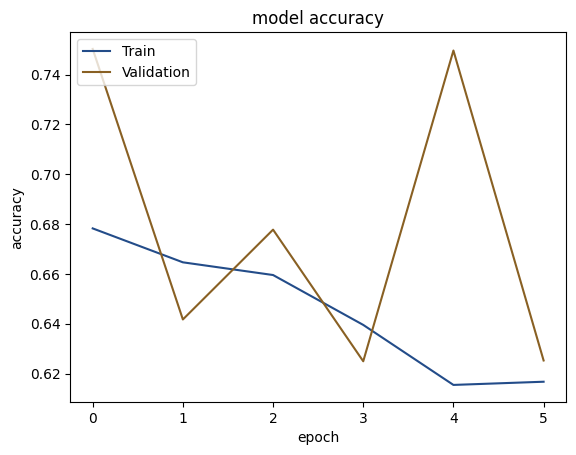

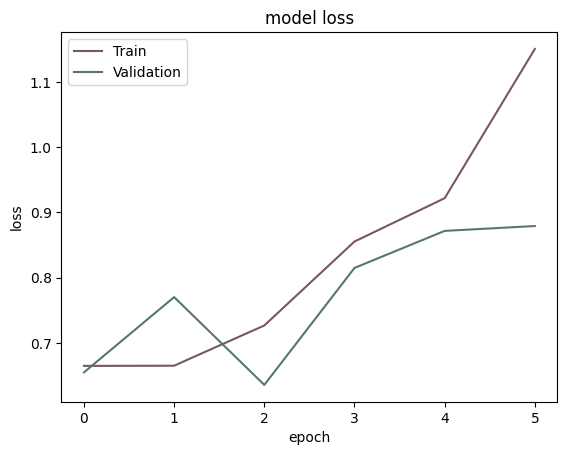

In [ ]:
# summarize history for accuracy
plt.plot(star_rating_history.history['accuracy'],color='#234C89')
plt.plot(star_rating_history.history['val_accuracy'], color = '#896023')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(star_rating_history.history['loss'], color = '#785665')
plt.plot(star_rating_history.history['val_loss'], color = '#567869')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Evaluation

In [ ]:
predictions = model.predict(x_test1)
star_rating_test_loss, star_rating_test_acc = model.evaluate(x_test1, y_test1)
print(f"test_acc: {star_rating_test_acc}")
print(f"test_loss: {star_rating_test_loss}")

725/725 [==============================] - 9s 12ms/step - loss: 0.8877 - accuracy: 0.6211
test_acc: 0.6210617423057556
test_loss: 0.887658417224884


Accuracy is **75%**

####Second sub version: Label Encoding

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model.add(GRU(150,return_sequences=True))
model.add(GRU(200,return_sequences=True))
model.add(GRU(80))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          13322100  
                                                                 
 gru_3 (GRU)                 (None, 300, 150)          203400    
                                                                 
 gru_4 (GRU)                 (None, 300, 200)          211200    
                                                                 
 gru_5 (GRU)                 (None, 80)                67680     
                                                                 
 dense_2 (Dense)             (None, 100)               8100      
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 13,812,682
Trainable params: 13,812,682


In [ ]:
student_rating = model.fit(x_train2, y_train2, batch_size=128, epochs=6, validation_data=(x_val2, y_val2))

Epoch 1/6
580/580 [==============================] - 41s 68ms/step - loss: 0.6629 - accuracy: 0.7074 - val_loss: 0.6568 - val_accuracy: 0.7500
Epoch 2/6
580/580 [==============================] - 29s 50ms/step - loss: 0.6683 - accuracy: 0.6975 - val_loss: 0.6543 - val_accuracy: 0.7503
Epoch 3/6
580/580 [==============================] - 30s 51ms/step - loss: 0.6348 - accuracy: 0.6847 - val_loss: 0.5949 - val_accuracy: 0.6777
Epoch 4/6
580/580 [==============================] - 30s 51ms/step - loss: 0.6265 - accuracy: 0.6782 - val_loss: 0.6845 - val_accuracy: 0.7076
Epoch 5/6
580/580 [==============================] - 28s 48ms/step - loss: 0.7550 - accuracy: 0.6488 - val_loss: 0.6767 - val_accuracy: 0.7414
Epoch 6/6
580/580 [==============================] - 28s 48ms/step - loss: 0.8680 - accuracy: 0.6593 - val_loss: 0.6112 - val_accuracy: 0.6861


######Visualizing - Model 1 - 2 (Label Encoding)

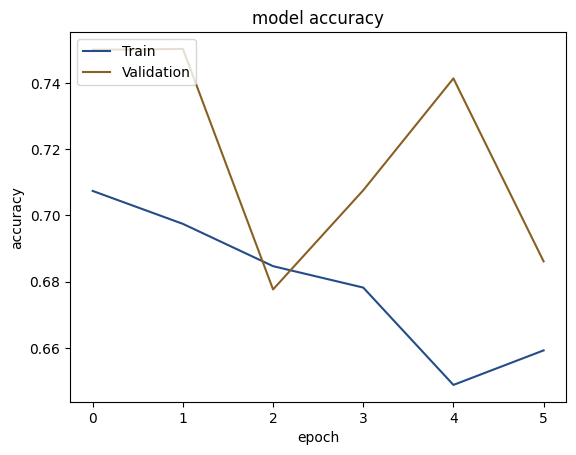

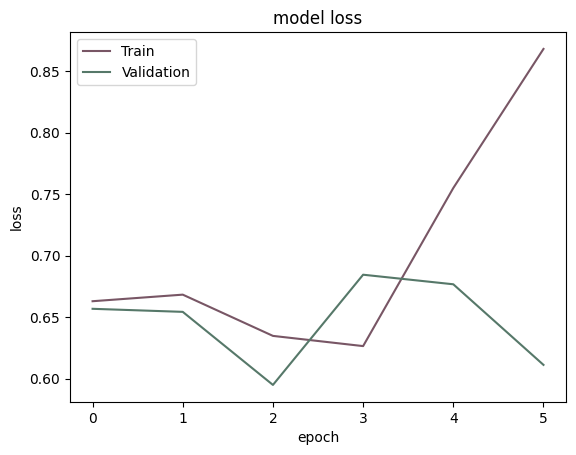

In [ ]:
# summarize history for accuracy
plt.plot(student_rating.history['accuracy'],color='#234C89')
plt.plot(student_rating.history['val_accuracy'], color = '#896023')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(student_rating.history['loss'], color = '#785665')
plt.plot(student_rating.history['val_loss'], color = '#567869')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###### Evaluation

In [ ]:
predictions = model.predict(x_test2)
star_rating_test_loss, star_rating_test_acc = model.evaluate(x_test2, y_test2)
print(f"test_acc: {star_rating_test_acc}")
print(f"test_loss: {star_rating_test_loss}")

725/725 [==============================] - 8s 11ms/step - loss: 0.6143 - accuracy: 0.6807
test_acc: 0.6806646585464478
test_loss: 0.6143314242362976


Accuracy dropped significantly, as described earlier, this is becuase using two columns as y without preprocessing would not give us a good accuracy.

####Third sub version: Raw
Using model 1- on a raw data (without using sentiment or label encoder)

We have also tried to train the model without applying sentiment function or feature encoding on our target variables to compare the results.  

In [ ]:
model1 = Sequential()

model1.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model1.add(GRU(150,return_sequences=True))
model1.add(GRU(200,return_sequences=True))
model1.add(GRU(80))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(2, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          13322100  
                                                                 
 gru_6 (GRU)                 (None, 300, 150)          203400    
                                                                 
 gru_7 (GRU)                 (None, 300, 200)          211200    
                                                                 
 gru_8 (GRU)                 (None, 80)                67680     
                                                                 
 dense_4 (Dense)             (None, 100)               8100      
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 13,812,682
Trainable params: 13,812,682


In [ ]:
student_rating1 = model1.fit(x_train3, y_train3, batch_size=128, epochs=6, validation_data=(x_val3, y_val3))

Epoch 1/6
580/580 [==============================] - 42s 68ms/step - loss: 0.6475 - accuracy: 0.6773 - val_loss: 0.5993 - val_accuracy: 0.7059
Epoch 2/6
580/580 [==============================] - 30s 51ms/step - loss: 0.6409 - accuracy: 0.6769 - val_loss: 0.6900 - val_accuracy: 0.7001
Epoch 3/6
580/580 [==============================] - 29s 50ms/step - loss: 0.6861 - accuracy: 0.6400 - val_loss: 0.6827 - val_accuracy: 0.7392
Epoch 4/6
580/580 [==============================] - 28s 49ms/step - loss: 0.8042 - accuracy: 0.6198 - val_loss: 0.9352 - val_accuracy: 0.7503
Epoch 5/6
580/580 [==============================] - 28s 48ms/step - loss: 0.7234 - accuracy: 0.6294 - val_loss: 0.7093 - val_accuracy: 0.5700
Epoch 6/6
580/580 [==============================] - 28s 48ms/step - loss: 0.8436 - accuracy: 0.6087 - val_loss: 0.6332 - val_accuracy: 0.6388


######Visualizing - Model 1 - 3 (Raw)

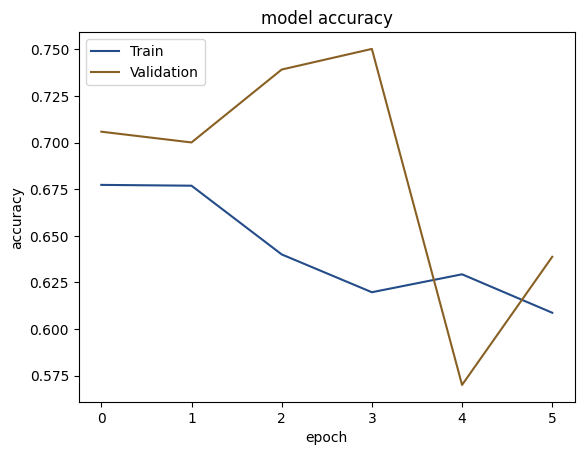

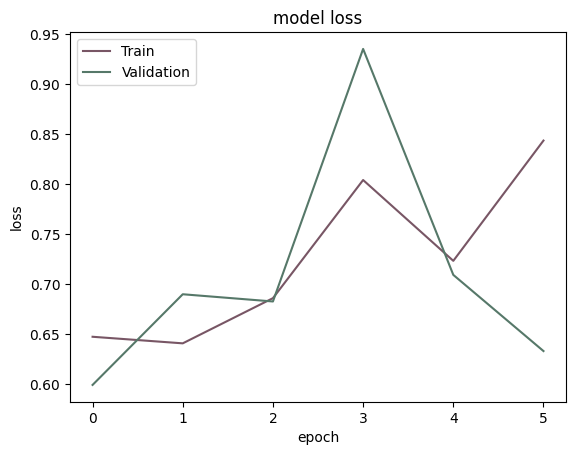

In [ ]:
# summarize history for accuracy
plt.plot(student_rating1.history['accuracy'],color='#234C89')
plt.plot(student_rating1.history['val_accuracy'], color = '#896023')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(student_rating1.history['loss'], color = '#785665')
plt.plot(student_rating1.history['val_loss'], color = '#567869')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###### Evaluation

In [ ]:
predictions = model1.predict(x_test3)
star_rating_test_loss, star_rating_test_acc = model1.evaluate(x_test3, y_test3)
print(f"test_acc: {star_rating_test_acc}")
print(f"test_loss: {star_rating_test_loss}")

725/725 [==============================] - 8s 11ms/step - loss: 0.6143 - accuracy: 0.6807
test_acc: 0.6806646585464478
test_loss: 0.6143314242362976


Accuracy dropped significantly, as described earlier, this is becuase using two columns as y without preprocessing would not give us a good accuracy.

### Conclusions

We are able to reach a max accuracy of 65% with this architecture. Surprisingly, the loss function goes up over epochs. The validation value is also all over the place. We do not believe this to be the correct approach to solving the problem.

##Model 2 - GRU with binary_crossentropy loss and sigmoid activation

Trying to search online to see if we can find any better loss function for predicting more than one dependent variable.

https://stackoverflow.com/questions/68874559/how-to-predict-multiple-dependent-columns-from-1-independent-column


According to the above website, we are going to use sigmoid for the activation function for output layer, also tried to use binary crossentropy for our loss function to compare the results.

####First Try using sentiment function for the dependent variables

In [ ]:
model2 = Sequential()

model2.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model2.add(GRU(150,return_sequences=True,activation='tanh'))
model2.add(GRU(200,return_sequences=True,activation='tanh'))
model2.add(GRU(80,activation='tanh'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          13322100  
                                                                 
 gru_9 (GRU)                 (None, 300, 150)          203400    
                                                                 
 gru_10 (GRU)                (None, 300, 200)          211200    
                                                                 
 gru_11 (GRU)                (None, 80)                67680     
                                                                 
 dense_6 (Dense)             (None, 100)               8100      
                                                                 
 dense_7 (Dense)             (None, 2)                 202       
                                                                 
Total params: 13,812,682
Trainable params: 13,812,682


In [ ]:
student_rating = model2.fit(x_train1, y_train1, batch_size=128, epochs=6, validation_data=(x_val1, y_val1))

Epoch 1/6
580/580 [==============================] - 41s 67ms/step - loss: 0.4769 - accuracy: 0.7895 - val_loss: 0.4385 - val_accuracy: 0.8295
Epoch 2/6
580/580 [==============================] - 29s 51ms/step - loss: 0.3989 - accuracy: 0.8218 - val_loss: 0.4177 - val_accuracy: 0.8041
Epoch 3/6
580/580 [==============================] - 27s 47ms/step - loss: 0.3482 - accuracy: 0.8343 - val_loss: 0.4380 - val_accuracy: 0.8060
Epoch 4/6
580/580 [==============================] - 27s 46ms/step - loss: 0.2964 - accuracy: 0.8435 - val_loss: 0.4791 - val_accuracy: 0.8123
Epoch 5/6
580/580 [==============================] - 26s 45ms/step - loss: 0.2469 - accuracy: 0.8477 - val_loss: 0.5715 - val_accuracy: 0.8021
Epoch 6/6
580/580 [==============================] - 26s 45ms/step - loss: 0.2031 - accuracy: 0.8529 - val_loss: 0.6883 - val_accuracy: 0.8015


######Visualizing - Model 2 - 1 (Sentiment Function)

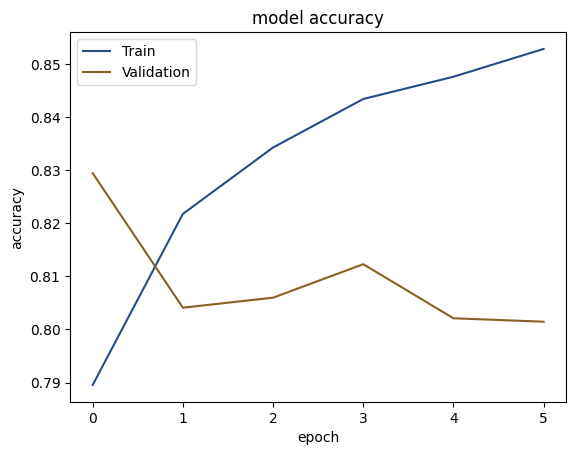

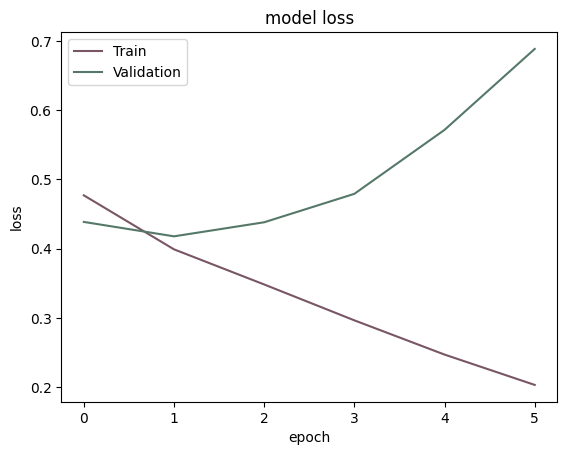

In [ ]:
# summarize history for accuracy
plt.plot(student_rating.history['accuracy'],color='#234C89')
plt.plot(student_rating.history['val_accuracy'], color = '#896023')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(student_rating.history['loss'], color = '#785665')
plt.plot(student_rating.history['val_loss'], color = '#567869')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Evaluation

In [ ]:
predictions = model2.predict(x_test1)
star_rating_test_loss, star_rating_test_acc = model2.evaluate(x_test1, y_test1)
print(f"test_acc: {star_rating_test_acc}")
print(f"test_loss: {star_rating_test_loss}")

725/725 [==============================] - 8s 11ms/step - loss: 0.7003 - accuracy: 0.8010
test_acc: 0.8009926676750183
test_loss: 0.7002703547477722


**Compared to Model 1, accuracy increased and loss function decreased which means using binary crossentropy as loss function and sigmoid for last layer activation function was a better choice for our model.**

####Train the second model using labelEncoder without using sentiment function for difficulty and rating

In [ ]:
model2 = Sequential()

model2.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model2.add(GRU(150,return_sequences=True,activation='tanh'))
model2.add(GRU(200,return_sequences=True,activation='tanh'))
model2.add(GRU(80,activation='tanh'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 300)          13322100  
                                                                 
 gru_12 (GRU)                (None, 300, 150)          203400    
                                                                 
 gru_13 (GRU)                (None, 300, 200)          211200    
                                                                 
 gru_14 (GRU)                (None, 80)                67680     
                                                                 
 dense_8 (Dense)             (None, 100)               8100      
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 13,812,682
Trainable params: 13,812,682


In [ ]:
student_rating2 = model2.fit(x_train2, y_train2, batch_size=128, epochs=6, validation_data=(x_val2, y_val2))

Epoch 1/6
580/580 [==============================] - 40s 65ms/step - loss: 0.4835 - accuracy: 0.7852 - val_loss: 0.4396 - val_accuracy: 0.7845
Epoch 2/6
580/580 [==============================] - 28s 48ms/step - loss: 0.4002 - accuracy: 0.8205 - val_loss: 0.4231 - val_accuracy: 0.8103
Epoch 3/6
580/580 [==============================] - 27s 46ms/step - loss: 0.3480 - accuracy: 0.8341 - val_loss: 0.4403 - val_accuracy: 0.8091
Epoch 4/6
580/580 [==============================] - 26s 45ms/step - loss: 0.2957 - accuracy: 0.8420 - val_loss: 0.4852 - val_accuracy: 0.7861
Epoch 5/6
580/580 [==============================] - 26s 45ms/step - loss: 0.2446 - accuracy: 0.8438 - val_loss: 0.5675 - val_accuracy: 0.8141
Epoch 6/6
580/580 [==============================] - 26s 45ms/step - loss: 0.1994 - accuracy: 0.8456 - val_loss: 0.6703 - val_accuracy: 0.7950


##### Visualizing - Model 2 - 2 (Label Encoding)

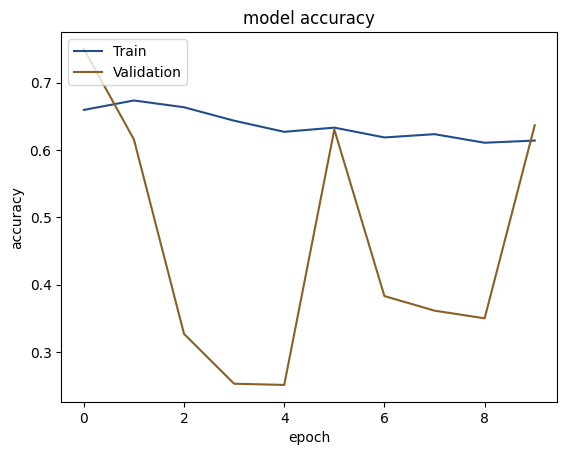

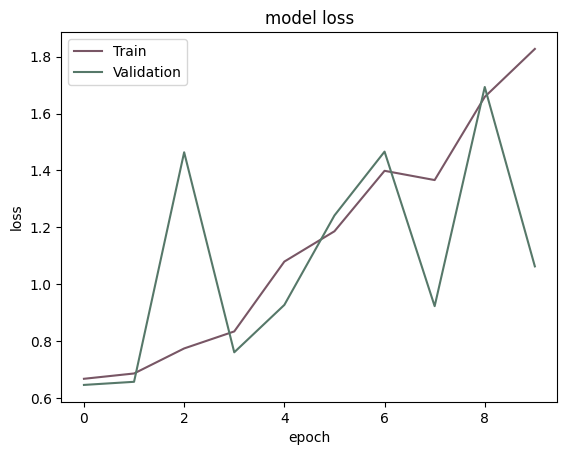

In [ ]:
# summarize history for accuracy
plt.plot(student_rating2.history['accuracy'],color='#234C89')
plt.plot(student_rating2.history['val_accuracy'], color = '#896023')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(student_rating2.history['loss'], color = '#785665')
plt.plot(student_rating2.history['val_loss'], color = '#567869')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Evaluation

In [ ]:
predictions = model2.predict(x_test2)
star_rating_test_loss, star_rating_test_acc = model2.evaluate(x_test2, y_test2)
print(f"test_acc: {star_rating_test_acc}")
print(f"test_loss: {star_rating_test_loss}")

725/725 [==============================] - 8s 11ms/step - loss: 0.6661 - accuracy: 0.7981
test_acc: 0.798101007938385
test_loss: 0.6660643815994263


**NOTE:**  
Binary cross entropy is not a right option for this model since we didn't convert the output (student rating and difficulty) to binary value (0 and 1). For that reason the loss value is highly negative, but since accuracy increased significantly compare to model1, we are going to try training the same model with different loss function -- **categorical_crossentropy**

In [ ]:
#from keras.backend import dropout
model2 = Sequential()

model2.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model2.add(GRU(150,return_sequences=True, activation='tanh'))
model2.add(Dropout(0.7))
model2.add(GRU(200,return_sequences=True,activation='tanh'))
model2.add(Dropout(0.7))
model2.add(GRU(80,activation='tanh'))
model2.add(Dropout(0.7))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 300)          13322100  
                                                                 
 gru_15 (GRU)                (None, 300, 150)          203400    
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 gru_16 (GRU)                (None, 300, 200)          211200    
                                                                 
 dropout_1 (Dropout)         (None, 300, 200)          0         
                                                                 
 gru_17 (GRU)                (None, 80)                67680     
                                                                 
 dropout_2 (Dropout)         (None, 80)               

In [ ]:
student_rating2 = model2.fit(x_train2, y_train2, batch_size=128, epochs=10, validation_data=(x_val2, y_val2))

Epoch 1/10
580/580 [==============================] - 41s 66ms/step - loss: 0.6673 - accuracy: 0.6596 - val_loss: 0.6458 - val_accuracy: 0.7503
Epoch 2/10
580/580 [==============================] - 29s 49ms/step - loss: 0.6860 - accuracy: 0.6737 - val_loss: 0.6567 - val_accuracy: 0.6157
Epoch 3/10
580/580 [==============================] - 27s 46ms/step - loss: 0.7741 - accuracy: 0.6635 - val_loss: 1.4639 - val_accuracy: 0.3267
Epoch 4/10
580/580 [==============================] - 26s 45ms/step - loss: 0.8339 - accuracy: 0.6436 - val_loss: 0.7605 - val_accuracy: 0.2526
Epoch 5/10
580/580 [==============================] - 26s 46ms/step - loss: 1.0795 - accuracy: 0.6270 - val_loss: 0.9271 - val_accuracy: 0.2509
Epoch 6/10
580/580 [==============================] - 28s 48ms/step - loss: 1.1861 - accuracy: 0.6333 - val_loss: 1.2417 - val_accuracy: 0.6304
Epoch 7/10
580/580 [==============================] - 28s 48ms/step - loss: 1.3987 - accuracy: 0.6187 - val_loss: 1.4662 - val_accuracy:

Loss function is still high, and trends upwards. We do not think it is worth trying to optimize this further.

####Third version Train the second model on a raw data (without using sentiment or labelEncoder)

In [ ]:
model2 = Sequential()

model2.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model2.add(GRU(150,return_sequences=True,activation='tanh'))
model2.add(GRU(200,return_sequences=True,activation='tanh'))
model2.add(GRU(80,activation='tanh'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 300)          13322100  
                                                                 
 gru_18 (GRU)                (None, 300, 150)          203400    
                                                                 
 gru_19 (GRU)                (None, 300, 200)          211200    
                                                                 
 gru_20 (GRU)                (None, 80)                67680     
                                                                 
 dense_12 (Dense)            (None, 100)               8100      
                                                                 
 dense_13 (Dense)            (None, 2)                 202       
                                                                 
Total params: 13,812,682
Trainable params: 13,812,682


In [ ]:
student_rating3 = model2.fit(x_train3, y_train3, batch_size=128, epochs=6, validation_data=(x_val3, y_val3))

Epoch 1/6
580/580 [==============================] - 40s 65ms/step - loss: 0.4787 - accuracy: 0.7859 - val_loss: 0.4347 - val_accuracy: 0.8256
Epoch 2/6
580/580 [==============================] - 28s 49ms/step - loss: 0.3990 - accuracy: 0.8210 - val_loss: 0.4184 - val_accuracy: 0.8063
Epoch 3/6
580/580 [==============================] - 27s 46ms/step - loss: 0.3503 - accuracy: 0.8314 - val_loss: 0.4278 - val_accuracy: 0.8105
Epoch 4/6
580/580 [==============================] - 26s 44ms/step - loss: 0.2983 - accuracy: 0.8389 - val_loss: 0.4650 - val_accuracy: 0.7994
Epoch 5/6
580/580 [==============================] - 26s 45ms/step - loss: 0.2496 - accuracy: 0.8458 - val_loss: 0.5887 - val_accuracy: 0.7951
Epoch 6/6
580/580 [==============================] - 26s 45ms/step - loss: 0.2038 - accuracy: 0.8404 - val_loss: 0.6913 - val_accuracy: 0.7844


######Visualizing - Model 2 - 3 (Raw data)

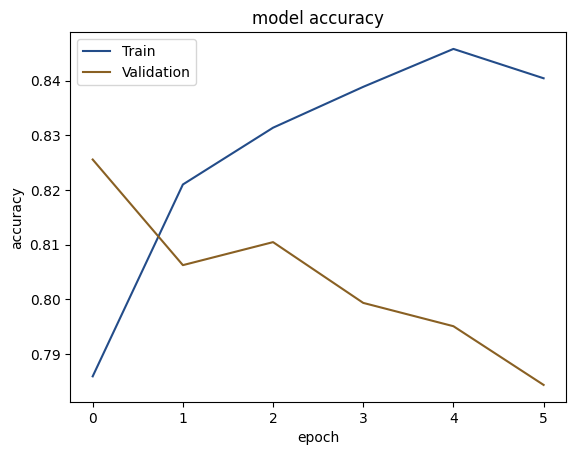

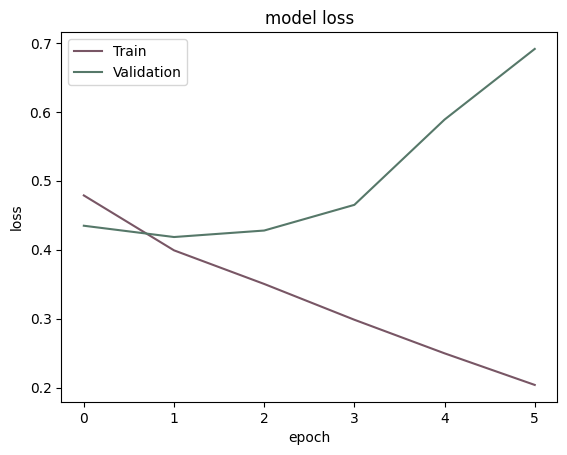

In [ ]:
# summarize history for accuracy
plt.plot(student_rating3.history['accuracy'],color='#234C89')
plt.plot(student_rating3.history['val_accuracy'], color = '#896023')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(student_rating3.history['loss'], color = '#785665')
plt.plot(student_rating3.history['val_loss'], color = '#567869')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###### Evaluation

In [ ]:
predictions = model2.predict(x_test3)
star_rating_test_loss, star_rating_test_acc = model.evaluate(x_test3, y_test3)
print(f"test_acc: {star_rating_test_acc}")
print(f"test_loss: {star_rating_test_loss}")

725/725 [==============================] - 8s 11ms/step - loss: 0.6143 - accuracy: 0.6807
test_acc: 0.6806646585464478
test_loss: 0.6143314242362976


Accuracy dropped significantly, as described earlier, this is because using two columns as y without preprocessing would not give us a good accuracy.

## Conclusions
We hit a higher accuracy on this model vs the previous one. Both data pre-processed with sentiment function as well as raw data seemed to perform really well, netting us an accuracy of 85% and a very low loss value. The performance of the model pre-processed with LabelEncoder seemed to be all over the place, with the loss value increasing over epoch.

##Model 3 - LSTM with binary_crossentropy loss and sigmoid activation

Compare to GRU, as expected LSTM took a longer time to fit the model. On local runtime this difference was negligible (about 30 seconds). We used the same loss and activation functions as previously as they've performed well in that case.

####First train the model on Sentiment Function preprocessed data

In [ ]:
model3 = Sequential()

model3.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model3.add(LSTM(150,return_sequences=True))
model3.add(LSTM(200,return_sequences=True))
model3.add(LSTM(80))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(2, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 300, 300)          13322100  
                                                                 
 lstm (LSTM)                 (None, 300, 150)          270600    
                                                                 
 lstm_1 (LSTM)               (None, 300, 200)          280800    
                                                                 
 lstm_2 (LSTM)               (None, 80)                89920     
                                                                 
 dense_14 (Dense)            (None, 100)               8100      
                                                                 
 dense_15 (Dense)            (None, 2)                 202       
                                                                 
Total params: 13,971,722
Trainable params: 13,971,722


In [ ]:
student_rating = model3.fit(x_train1, y_train1, batch_size=128, epochs=6, validation_data=(x_val1, y_val1))

Epoch 1/6
580/580 [==============================] - 43s 69ms/step - loss: 0.4912 - accuracy: 0.7861 - val_loss: 0.4520 - val_accuracy: 0.8252
Epoch 2/6
580/580 [==============================] - 30s 52ms/step - loss: 0.4086 - accuracy: 0.8203 - val_loss: 0.4250 - val_accuracy: 0.8149
Epoch 3/6
580/580 [==============================] - 29s 51ms/step - loss: 0.3579 - accuracy: 0.8330 - val_loss: 0.4370 - val_accuracy: 0.8016
Epoch 4/6
580/580 [==============================] - 28s 49ms/step - loss: 0.3088 - accuracy: 0.8400 - val_loss: 0.4770 - val_accuracy: 0.7946
Epoch 5/6
580/580 [==============================] - 28s 48ms/step - loss: 0.2637 - accuracy: 0.8455 - val_loss: 0.5445 - val_accuracy: 0.7938
Epoch 6/6
580/580 [==============================] - 28s 48ms/step - loss: 0.2218 - accuracy: 0.8494 - val_loss: 0.6060 - val_accuracy: 0.8023


######Visualizing - Model 3 - 1 (Sentiment Function)

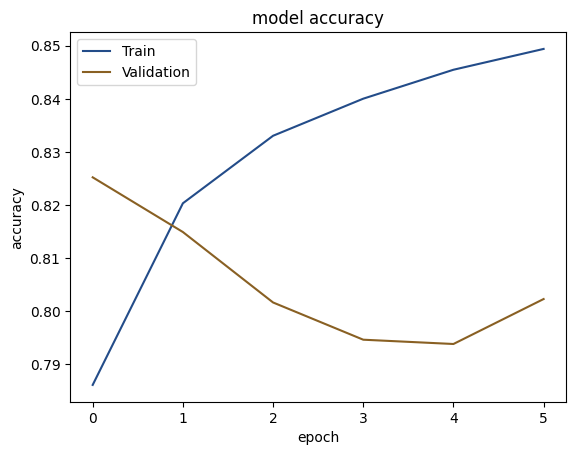

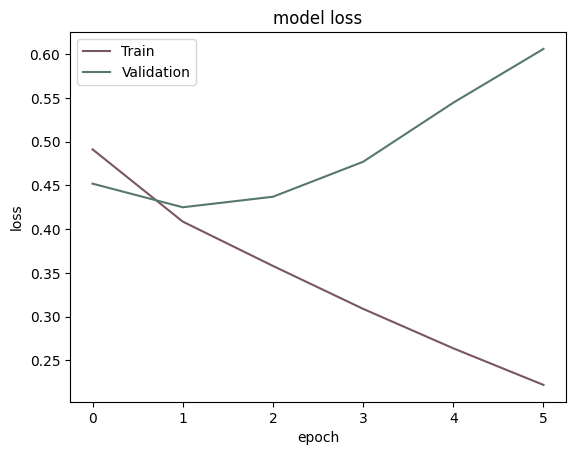

In [ ]:
# summarize history for accuracy
plt.plot(student_rating.history['accuracy'],color='#234C89')
plt.plot(student_rating.history['val_accuracy'], color = '#896023')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(student_rating.history['loss'], color = '#785665')
plt.plot(student_rating.history['val_loss'], color = '#567869')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Evaluation

In [ ]:
predictions = model3.predict(x_test1)
star_rating_test_loss, star_rating_test_acc = model3.evaluate(x_test1, y_test1)
print(f"test_acc: {star_rating_test_acc}")
print(f"test_loss: {star_rating_test_loss}")

725/725 [==============================] - 9s 12ms/step - loss: 0.6075 - accuracy: 0.8068
test_acc: 0.8067759871482849
test_loss: 0.6074816584587097


It took longer time for this model to run, but we were able to gain better accuracy and lower loos value. Which means that LSTM perfomed better on our model compare to GRU.

####Train model 3 using labelEncoder without sentiment analysis for difficulty and rating - model 3

In [ ]:
model3 = Sequential()

model3.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model3.add(LSTM(150,return_sequences=True))
model3.add(LSTM(200,return_sequences=True))
model3.add(LSTM(80))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(2, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 300, 300)          13322100  
                                                                 
 lstm_6 (LSTM)               (None, 300, 150)          270600    
                                                                 
 lstm_7 (LSTM)               (None, 300, 200)          280800    
                                                                 
 lstm_8 (LSTM)               (None, 80)                89920     
                                                                 
 dense_26 (Dense)            (None, 100)               8100      
                                                                 
 dense_27 (Dense)            (None, 2)                 202       
                                                                 
Total params: 13,971,722
Trainable params: 13,971,722

In [ ]:
student_rating3 = model3.fit(x_train2, y_train2, batch_size=128, epochs=6, validation_data=(x_val2, y_val2))

Epoch 1/6
580/580 [==============================] - 46s 76ms/step - loss: 0.4895 - accuracy: 0.7885 - val_loss: 0.4420 - val_accuracy: 0.8146
Epoch 2/6
580/580 [==============================] - 32s 55ms/step - loss: 0.4070 - accuracy: 0.8195 - val_loss: 0.4319 - val_accuracy: 0.7909
Epoch 3/6
580/580 [==============================] - 32s 55ms/step - loss: 0.3590 - accuracy: 0.8305 - val_loss: 0.4477 - val_accuracy: 0.8027
Epoch 4/6
580/580 [==============================] - 31s 53ms/step - loss: 0.3100 - accuracy: 0.8384 - val_loss: 0.4639 - val_accuracy: 0.8079
Epoch 5/6
580/580 [==============================] - 31s 54ms/step - loss: 0.2654 - accuracy: 0.8437 - val_loss: 0.5208 - val_accuracy: 0.7965
Epoch 6/6
580/580 [==============================] - 29s 50ms/step - loss: 0.2228 - accuracy: 0.8459 - val_loss: 0.6244 - val_accuracy: 0.7879


######Visualizing - Model 3 - 2 (Label Encoding)

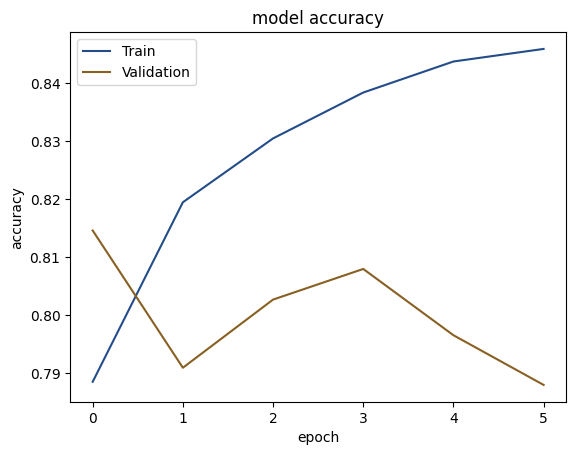

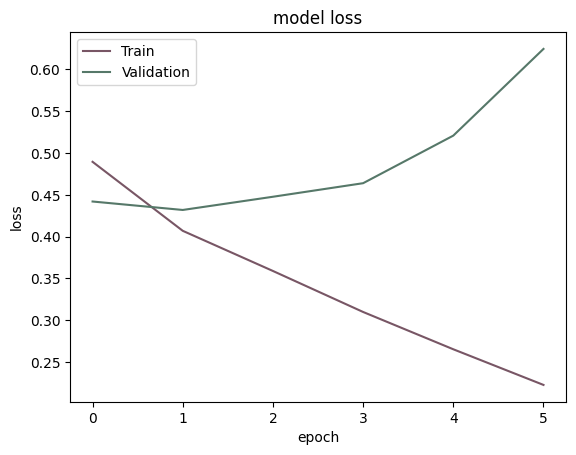

In [ ]:
# summarize history for accuracy
plt.plot(student_rating3.history['accuracy'],color='#234C89')
plt.plot(student_rating3.history['val_accuracy'], color = '#896023')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(student_rating3.history['loss'], color = '#785665')
plt.plot(student_rating3.history['val_loss'], color = '#567869')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###### Evaluation

In [ ]:
predictions = model3.predict(x_test2)
star_rating_test_loss, star_rating_test_acc = model.evaluate(x_test2, y_test2)
print(f"test_acc: {star_rating_test_acc}")
print(f"test_loss: {star_rating_test_loss}")

725/725 [==============================] - 8s 11ms/step - loss: 0.6143 - accuracy: 0.6807
test_acc: 0.6806646585464478
test_loss: 0.6143314242362976


####Train model 3 using raw data

Accuracy dropped significantly, as described earlier, this is becuase using two columns as y without preprocessing would not give us a good accuracy.

In [ ]:
model3 = Sequential()

model3.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model3.add(LSTM(150,return_sequences=True))
model3.add(LSTM(200,return_sequences=True))
model3.add(LSTM(80))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(2, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 300, 300)          13322100  
                                                                 
 lstm_9 (LSTM)               (None, 300, 150)          270600    
                                                                 
 lstm_10 (LSTM)              (None, 300, 200)          280800    
                                                                 
 lstm_11 (LSTM)              (None, 80)                89920     
                                                                 
 dense_28 (Dense)            (None, 100)               8100      
                                                                 
 dense_29 (Dense)            (None, 2)                 202       
                                                                 
Total params: 13,971,722
Trainable params: 13,971,722

In [ ]:
student_rating3 = model3.fit(x_train3, y_train3, batch_size=128, epochs=6, validation_data=(x_val3, y_val3))

Epoch 1/6
580/580 [==============================] - 45s 74ms/step - loss: 0.4949 - accuracy: 0.7838 - val_loss: 0.4501 - val_accuracy: 0.7955
Epoch 2/6
540/580 [==========================>...] - ETA: 2s - loss: 0.4125 - accuracy: 0.8156

KeyboardInterrupt: ignored

######Visualizing - Model 3 - 3 (Raw data)

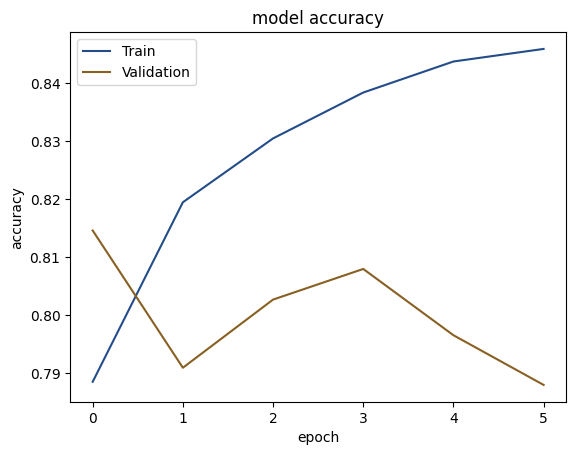

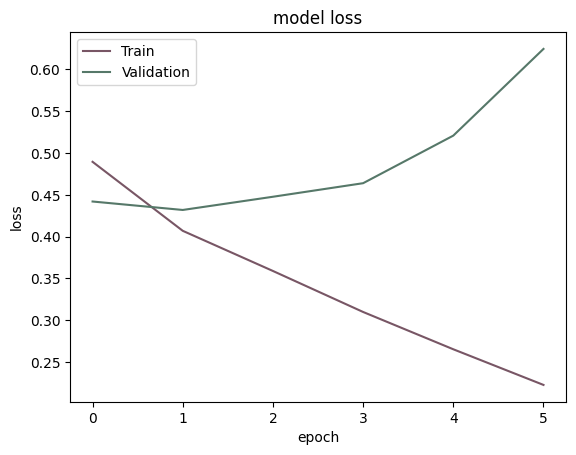

In [ ]:
# summarize history for accuracy
plt.plot(student_rating3.history['accuracy'],color='#234C89')
plt.plot(student_rating3.history['val_accuracy'], color = '#896023')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(student_rating3.history['loss'], color = '#785665')
plt.plot(student_rating3.history['val_loss'], color = '#567869')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###### Evaluation

In [ ]:
predictions = model3.predict(x_test2)
star_rating_test_loss, star_rating_test_acc = model.evaluate(x_test2, y_test2)
print(f"test_acc: {star_rating_test_acc}")
print(f"test_loss: {star_rating_test_loss}")

725/725 [==============================] - 8s 11ms/step - loss: 0.6143 - accuracy: 0.6807
test_acc: 0.6806646585464478
test_loss: 0.6143314242362976


We search more to see if we can get a better loss function for our model.

### Conclusions
This is the best performing model we have found so far.

##Model 4 - GRU with sparse_categorical_crossentropy and softmax activation

https://keras.io/api/losses/probabilistic_losses/#:~:text=SparseCategoricalCrossentropy%20class&text=%22sparse_categorical_crossentropy%22%2C%20)-,Computes%20the%20crossentropy%20loss%20between%20the%20labels%20and%20predictions.,to%20be%20provided%20as%20integers.

**According to keras website, we tried to use sparse_categorical_crossentropy for our loss function; however, whatever version we tried, we werren't able to fix the mismatch shapre error that was generated.**

In [ ]:
model4 = Sequential()

model4.add(Embedding(vocab_size, 300, weights=[embedding_matrix],
                     input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model4.add(GRU(150,return_sequences=True))

model4.add(GRU(200,return_sequences=True))

model4.add(GRU(80))
model4.add(Dense(100, activation='relu'))

model4.add(Dense(2, activation='softmax'))

model4.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 300, 300)          13322100  
                                                                 
 gru_21 (GRU)                (None, 300, 150)          203400    
                                                                 
 gru_22 (GRU)                (None, 300, 200)          211200    
                                                                 
 gru_23 (GRU)                (None, 80)                67680     
                                                                 
 dense_18 (Dense)            (None, 100)               8100      
                                                                 
 dense_19 (Dense)            (None, 2)                 202       
                                                                 
Total params: 13,812,682
Trainable params: 13,812,682


In [ ]:
student_rating_4 = model4.fit(x_train1, y_train1, batch_size=128, epochs=6,validation_data=(x_val1, y_val1))

Epoch 1/6


InvalidArgumentError: ignored

####Train the fourth model using labelEncoder without sentiment function

we hoped that using LabelEncoder library would fix the error but we still got the same error.

In [ ]:
import tensorflow as tf
model4 = Sequential()

model4.add(Embedding(vocab_size, 300, weights=[embedding_matrix],
                     input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model4.add(GRU(150,return_sequences=True))
model4.add(Dropout(0.3))
model4.add(GRU(200,return_sequences=True))

model4.add(GRU(80))
model4.add(Dense(100, activation='relu'))

model4.add(Dense(2, activation='softmax'))

#model4.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model4.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy())
model4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 300, 300)          13322100  
                                                                 
 gru_24 (GRU)                (None, 300, 150)          203400    
                                                                 
 dropout_3 (Dropout)         (None, 300, 150)          0         
                                                                 
 gru_25 (GRU)                (None, 300, 200)          211200    
                                                                 
 gru_26 (GRU)                (None, 80)                67680     
                                                                 
 dense_20 (Dense)            (None, 100)               8100      
                                                                 
 dense_21 (Dense)            (None, 2)               

In [ ]:
student_rating4 = model4.fit(x_train2, y_train2, batch_size=128, epochs=6,validation_data=(x_val1, y_val1))

Epoch 1/6


InvalidArgumentError: ignored

###Using model 4 on raw data (without using sentiment or label encoder)

In [ ]:
model4 = Sequential()

model4.add(Embedding(vocab_size, 300, weights=[embedding_matrix],
                     input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model4.add(GRU(150,return_sequences=True))

model4.add(GRU(200,return_sequences=True))

model4.add(GRU(80))
model4.add(Dense(100, activation='relu'))

model4.add(Dense(300, activation='softmax'))

model4.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 300, 300)          13322100  
                                                                 
 gru_27 (GRU)                (None, 300, 150)          203400    
                                                                 
 gru_28 (GRU)                (None, 300, 200)          211200    
                                                                 
 gru_29 (GRU)                (None, 80)                67680     
                                                                 
 dense_22 (Dense)            (None, 100)               8100      
                                                                 
 dense_23 (Dense)            (None, 300)               30300     
                                                                 
Total params: 13,842,780
Trainable params: 13,842,780

In [ ]:
student_rating4 = model4.fit(x_train3, y_train3, batch_size=128, epochs=6,validation_data=(x_val3, y_val3))

NameError: ignored

Even trying the model on raw data did not help us to fix the error of this model.

### Conclusions

We could not test this approach as we could not get it to work on our end.

#Conclusion of four models

**Comparision of Model 1, 2, 3, 4:**
* In general, using sentiment function to convert dependent variables to 0 and 1 gave us the best accuracy.
* `binary_crossentropy` was the best loss function that we used among all these three models.
* LSTM gave us better accuracy and lower loss value compare to GRU. We recall from class lectures that LSTM is slower to work with, but could give us better results. We believe that our findings is a reflection of this.
* We tried our best to make the `sparse_categorical_crossentropy` to work, but we weren't successful in that.

In the next section we are going to seperate rating from difficulty and try to train the model on that

#Challenge

# Train two models seperately (using the csv file)

In [ ]:
df = df.filter(['comments', 'student_star', 'student_difficult'])
df.head()
df.dropna(axis=0, how='any',inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115847 entries, 0 to 93075
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   comments           115847 non-null  object
 1   student_star       115847 non-null  int64 
 2   student_difficult  115847 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ MB


###Tokenizing comments

In [ ]:
df_review = df['comments']

In [ ]:
(count, col) = df.shape
texts = []
for i in range (0, count):
  texts.append(df_review.values[i])

In [ ]:
MAX_NB_WORDS = 30000
MAX_SEQUENCE_LENGTH = 300

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 44406 unique tokens.


In [ ]:
df2 = df.filter(['student_star', 'student_difficult'])

In [ ]:
df2['student_star'].value_counts()

student_star
1    66854
0    48993
Name: count, dtype: int64

In [ ]:
df2['student_difficult'].value_counts()

student_difficult
0    70189
1    45658
Name: count, dtype: int64

If we want to predict both of them at the same time without any pre-processing step (without converting them into 0 and 1) we won't be able to train them since each would generate different number of outputs; therefore, if don't want to preprocess them, we should train the model seperately for predicting each of them.

## Train the model for predicting difficulty score

In [ ]:
#converting the difficulty score to int
#df2['student_difficult'] = df['student_difficult'].astype(int)
#df2.info()

In [ ]:
df_difficulty = df2['student_difficult']

In [ ]:
#converting difficulty score into numpy array before splitting the data
y = df_difficulty.values
y

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
data

array([[   0,    0,    0, ...,   17,   16,    6],
       [   0,    0,    0, ...,  771,  677,   18],
       [   0,    0,    0, ...,    3,    1,  124],
       ...,
       [   0,    0,    0, ...,   16,   21,   45],
       [   0,    0,    0, ..., 1326,    1, 2114],
       [   0,    0,    0, ...,  592,   23,  953]], dtype=int32)

## Split data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state = 40)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 40)

In [ ]:
x_train.shape

(74141, 300)

In [ ]:
y_train.shape

(74141,)

## Creating the embeding layer

In [ ]:
embeddings_index = dict()

if not isLocal:
	f = open('/content/drive/MyDrive/CPSC585_GP_10/glove_6B/glove.6B.300d.txt')
else:
	f = open('./glove.6B.300d.txt')

for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
vocab = tokenizer.sequences_to_texts(texts)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

print (vocab_size)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.
44407


## Train the model

In [ ]:
from tensorflow import keras
model5 = Sequential()

model5.add(Embedding(vocab_size, 300, weights=[embedding_matrix],
                     input_length=(MAX_SEQUENCE_LENGTH), trainable=True))
model5.add(GRU(150,return_sequences=True))

model5.add(GRU(200,return_sequences=True))

model5.add(Dropout(0.4))
model5.add(GRU(100,return_sequences=True))
model5.add(GRU(80))
model5.add(Dense(100, activation='relu'))
model5.add(Dropout(0.4))
model5.add(Dense(1, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01) #to increase the accuracy
model5.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])

model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 300, 300)          13322100  
                                                                 
 gru_30 (GRU)                (None, 300, 150)          203400    
                                                                 
 gru_31 (GRU)                (None, 300, 200)          211200    
                                                                 
 dropout_4 (Dropout)         (None, 300, 200)          0         
                                                                 
 gru_32 (GRU)                (None, 300, 100)          90600     
                                                                 
 gru_33 (GRU)                (None, 80)                43680     
                                                                 
 dense_24 (Dense)            (None, 100)             

In [ ]:
student_difficulty = model5.fit(x_train, y_train, batch_size=128, epochs=6, validation_data=(x_val, y_val))

Epoch 1/6
580/580 [==============================] - 51s 81ms/step - loss: 0.6047 - accuracy: 0.3953 - val_loss: 0.6062 - val_accuracy: 0.3938
Epoch 2/6
580/580 [==============================] - 38s 65ms/step - loss: 0.6047 - accuracy: 0.3953 - val_loss: 0.6062 - val_accuracy: 0.3938
Epoch 3/6
580/580 [==============================] - 37s 64ms/step - loss: 0.6047 - accuracy: 0.3953 - val_loss: 0.6062 - val_accuracy: 0.3938
Epoch 4/6
580/580 [==============================] - 37s 63ms/step - loss: 0.6047 - accuracy: 0.3953 - val_loss: 0.6062 - val_accuracy: 0.3938
Epoch 5/6
580/580 [==============================] - 36s 62ms/step - loss: 0.6047 - accuracy: 0.3953 - val_loss: 0.6062 - val_accuracy: 0.3938
Epoch 6/6
580/580 [==============================] - 36s 61ms/step - loss: 0.6047 - accuracy: 0.3953 - val_loss: 0.6062 - val_accuracy: 0.3938


* If We want to train the model such that the model predicts each column seperatly, we have to use regression loss functions since the output will be considered as non categorical data. As a result, we tried to use mean absolute error for our loss function.
* We tried our best to add layers to model to increase the accuracy; however, we weren't able to increase the accuracy. In addition, learning time was very slow when we tired to fit the model.
* we tried LabelEncoder for our target value to increase the accuracy, but still was not able to get an acceptable accuracy.
* In general, we think it would be easier to train the model when two columns (difficulty and rating) are combined and considered as one y value. Preprocessing the data was also a key element for increasing the accuracy.  